# Perturb-seq K562 co-expression

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import pickle as pkl
import gseapy as gp
from gseapy.plot import gseaplot

%matplotlib inline

In [2]:
pd.set_option('max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/k562/'

### Read the guide labled K562 data

From perturbseq paper

In [5]:
adata = sc.read(data_path + 'h5ad/filtered-tf-perturbseq.h5ad')

In [6]:
guides = adata.obs.guides.drop_duplicates().tolist()
guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

### Setup memento

In [7]:
adata.obs['q'] = 0.07

In [8]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.15)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned


### Do a 1D test to find highly variable genes

In [12]:
wt_subset = adata[adata.obs.WT].copy().copy()
wt_subset.obs['group'] = 1
memento.create_groups(wt_subset, label_columns=['group'])
memento.compute_1d_moments(wt_subset, min_perc_group=.9)
memento.ht_1d_moments(
    wt_subset, 
    formula_like='1',
    treatment_col='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=70,
    resampling='permutation',
    approx=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    3.6s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    5.5s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    8.0s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   11.0s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   14.8s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   19.2s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   24.8s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   30.7s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:   37.6s
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:   44.5s
[Parallel(n_j

In [13]:
wt_subset = sc.read(data_path + 'wt_1d.h5ad')

In [14]:
df = memento.get_1d_ht_result(wt_subset).query('~gene.str.startswith("MT-")', engine='python')

In [15]:
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

In [16]:
hvg = df.query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

Text(0, 0.5, 'Variability')

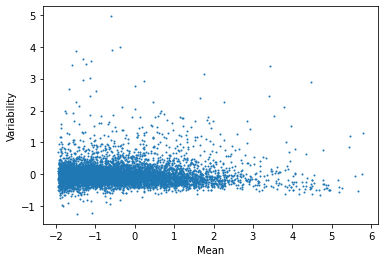

In [17]:
plt.scatter(df['de_coef'], df['dv_coef'], s=1); plt.xlabel('Mean'); plt.ylabel('Variability')

### GSEA for WT

In [18]:
import gseapy as gp
from gseapy.plot import gseaplot


In [19]:
pre_res = gp.prerank(
    rnk=df[['gene','dv_coef']].sort_values('dv_coef'), 
    gene_sets='GO_Biological_Process_2018',
    processes=14,
    permutation_num=100, # reduce number to speed up testing
    outdir=None, seed=6)

In [20]:
terms = pre_res.res2d.index


In [21]:
gsea_table = pre_res.res2d.sort_index().sort_values('fdr')


In [22]:
gsea_table.query('es > 0').head(10)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
regulation of immune response (GO:0050776),0.730837,2.088488,0.0,0.009694,252,28,TYROBP;IFITM1;CD3D;B2M;CD33;HLA-E;ICAM2;NCR3LG...,TYROBP;IFITM1;CD3D;B2M;CD33
cellular response to hormone stimulus (GO:0032870),0.770491,2.201558,0.0,0.009694,81,28,JUN;TFPI;SOCS2;AKR1C1;MEF2C;CTSL;ZFP36L1;LMO2;...,JUN;TFPI;SOCS2;AKR1C1;MEF2C;CTSL;ZFP36L1;LMO2;...
response to unfolded protein (GO:0006986),0.722181,2.096073,0.0,0.012926,44,29,HSPA1A;HSPA5;DNAJB4;HSPA8;DNAJB1;HERPUD1;HSP90...,HSPA1A;HSPA5;DNAJB4;HSPA8;DNAJB1;HERPUD1;HSP90...
defense response to bacterium (GO:0042742),0.764943,2.132035,0.0,0.014541,242,27,LYZ;PYCARD;RPL39;HIST1H2BJ;HIST1H2BK;HMGB2;HIS...,LYZ;PYCARD;RPL39;HIST1H2BJ;HIST1H2BK;HMGB2;HIS...
lymphocyte differentiation (GO:0030098),0.743540,1.997293,0.0,0.022158,74,18,CD3D;KLF6;PTPRC;DNAJB9;HHEX;RHOH;LYL1;CHD7;JAG...,CD3D;KLF6;PTPRC;DNAJB9;HHEX;RHOH
regulation of DNA binding (GO:0051101),0.725346,2.003885,0.0,0.024235,53,35,ID3;ID1;IGF1;JUN;HJURP;HMGB2;IFI16;HES1;PLAUR;...,ID3;ID1;IGF1;JUN;HJURP;HMGB2;IFI16;HES1;PLAUR
chaperone mediated protein folding requiring cofactor (GO:0051085),0.746605,2.008710,0.0,0.027144,25,18,HSPA1A;HSPA5;HSPA8;DNAJB1;HSPH1;HSPA4L;GAK;PTG...,HSPA1A;HSPA5;HSPA8;DNAJB1;HSPH1
negative regulation of apoptotic process (GO:0043066),0.528204,1.949702,0.0,0.056953,486,219,DHRS2;HSPA1A;APOE;HSPA5;IGF1;HSP90B1;SQSTM1;AR...,DHRS2;HSPA1A;APOE;HSPA5;IGF1;HSP90B1;SQSTM1;AR...
regulation of cell cycle (GO:0051726),0.552149,1.925963,0.0,0.058165,216,124,ID3;ID1;CCNB1;CDK1;JUN;CENPF;CKS2;PLK1;CCND1;C...,ID3;ID1;CCNB1;CDK1;JUN;CENPF;CKS2;PLK1;CCND1;C...


In [23]:
# # Define the gene sets

# stress_genes = list(set(gsea_table.query('es > 0').genes.iloc[2].split(';')) & set(hvg))
# bacteria_genes = list(set(gsea_table.query('es > 0').genes.iloc[3].split(';')) & set(hvg))
# immune_genes = list(set(gsea_table.query('es > 0').genes.iloc[0].split(';') +  gsea_table.query('es > 0').genes.iloc[4].split(';')) & set(hvg))

### Get HVG and LVG

In [24]:
hvg = df.query('dv_fdr < 0.05 & dv_coef > 1').gene.tolist()
lvg = df.query('dv_fdr < 0.05 & dv_coef < -0.5').gene.tolist()

Text(0, 0.5, 'Variability')

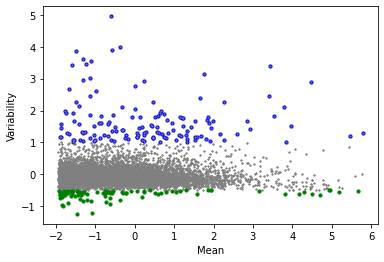

In [25]:
plt.scatter(df['de_coef'], df['dv_coef'], s=1, color='grey')
plt.scatter(df.query('gene in @hvg')['de_coef'], df.query('gene in @hvg')['dv_coef'], s=10, color='b')
plt.scatter(df['de_coef'], df['dv_coef'], s=1, color='grey')
plt.scatter(df.query('gene in @lvg')['de_coef'], df.query('gene in @lvg')['dv_coef'], s=10, color='g')
plt.xlabel('Mean'); plt.ylabel('Variability')

### Get cytokines

In [26]:
cytokines = pd.read_csv('mart_export.txt')['Gene name'].tolist()

In [27]:
df['cytokine'] = df['gene'].isin(cytokines)

In [28]:
df['cytokine'].sum()

29

In [29]:
cytokines = df.query('cytokine').gene.tolist()

(-1.0, 1.5)

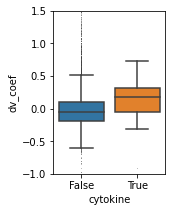

In [30]:
plt.figure(figsize=(2,3))
sns.boxplot(x='cytokine', y='dv_coef', data=df, fliersize=0.1)
plt.ylim(-1,1.5)

In [31]:
dv_cytokines = df.query('cytokine & dv_fdr < 0.1').gene.tolist()
df.query('cytokine & dv_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,cytokine
1627,IL20RB,-1.787209,0.037735,1.172974e-09,0.318886,0.142819,0.024898,0.087902,True
1849,CXCL3,-1.086986,0.028921,1.334252e-06,0.721656,0.123211,0.000017,0.000445,True
2133,TSLP,-1.427353,0.032898,1.618486e-07,0.546550,0.102552,0.000025,0.000561,True
2190,CXCL14,-1.703472,0.033080,7.985269e-06,-0.911718,0.233009,0.001900,0.011116,True
2549,VEGFA,-0.085674,0.016998,1.811198e-05,0.290479,0.082470,0.001570,0.009700,True
3184,TIMP1,1.759360,0.025869,9.483886e-08,3.132865,1.033516,0.000100,0.001355,True
3287,IL13RA1,-1.868375,0.042147,3.604690e-07,0.704446,0.201939,0.001072,0.007455,True
4810,IL23A,-1.112587,0.028282,7.818231e-07,0.519569,0.089996,0.000049,0.000844,True
6962,GDF15,1.142136,0.016518,2.538263e-09,1.807208,0.138331,0.000001,0.000124,True
7018,GPI,0.209889,0.013711,1.306109e-04,-0.310132,0.095801,0.001700,0.010225,True


### Memento

In [35]:
results = {}
moments = {}

In [36]:
for g in ko_genes:
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g)].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO',
        treatment_col='KO', 
        num_boot=20000, 
        verbose=1,
        num_cpus=92,
        resampling='permutation',
        approx=False)
    guide_df = memento.get_1d_ht_result(subset)
    
    results[g] = memento.get_1d_ht_result(subset)
    moments[g] = memento.get_1d_moments(subset, groupby='KO')
    
    results[g]['de_fdr'] = memento.util._fdrcorrect(results[g]['de_pval'])
    results[g]['dv_fdr'] = memento.util._fdrcorrect(results[g]['dv_pval'])
    
    results[g]['cytokine']= results[g].gene.apply(lambda x: x in cytokines)
    results[g]['class'] = results[g].gene.apply(lambda x: 'hvg' if x in hvg else 'lvg')

ELK1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.7s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    7.8s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   13.0s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   19.4s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   27.1s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   36.9s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   47.0s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   59.0s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.2min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.4min
[Parallel(n_jobs=92)]: Done 7466 out of 7466 | elapsed:  1.7min finished


ELF1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.8s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    8.1s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   13.4s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   20.0s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   27.8s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   37.9s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   48.2s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:  1.0min
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.2min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.5min
[Parallel(n_jobs=92)]: Done 7443 out of 7443 | elapsed:  1.7min finished


IRF1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.1s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    6.6s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   11.0s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   16.5s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   22.9s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   31.4s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   39.8s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   50.2s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.0min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.2min
[Parallel(n_jobs=92)]: Done 7422 out of 7422 | elapsed:  1.4min finished


ETS1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.6s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    7.6s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   12.6s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   18.8s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   26.2s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   35.7s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   45.4s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   57.0s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.4min
[Parallel(n_jobs=92)]: Done 7478 out of 7478 | elapsed:  1.6min finished


EGR1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.3s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    7.1s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   11.8s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   17.5s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   24.4s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   33.3s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   42.3s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   53.2s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.3min
[Parallel(n_jobs=92)]: Done 7469 out of 7469 | elapsed:  1.5min finished


YY1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.8s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    8.0s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   13.2s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   19.7s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   27.5s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   37.6s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   47.7s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   59.9s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.2min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.4min
[Parallel(n_jobs=92)]: Done 7329 out of 7329 | elapsed:  1.7min finished


GABPA


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.6s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    7.6s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   12.6s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   18.8s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   26.2s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   35.8s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   45.6s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   57.3s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.2min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.4min
[Parallel(n_jobs=92)]: Done 7405 out of 7405 | elapsed:  1.6min finished


E2F4


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.5s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    7.5s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   12.6s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   18.7s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   26.1s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   35.6s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   45.3s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   56.9s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.4min
[Parallel(n_jobs=92)]: Done 7438 out of 7438 | elapsed:  1.6min finished


NR2C2


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.5s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    7.5s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   12.5s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   18.8s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   26.0s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   35.5s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   45.2s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   56.8s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.4min
[Parallel(n_jobs=92)]: Done 7400 out of 7400 | elapsed:  1.6min finished


CREB1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.1s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    6.4s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   10.6s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   15.7s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   21.8s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   29.8s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   38.0s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   47.8s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:   57.6s
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.2min
[Parallel(n_jobs=92)]: Done 7424 out of 7424 | elapsed:  1.4min finished


In [41]:
filtered_results = {}
for g in ko_genes:
    
    filtered_results[g] = results[g].copy()
#     filtered_results[g]['class'] = filtered_results[g].gene.apply(lambda x: 'cytokine' if x in cytokines else 'else')
    filtered_results[g]['class'] = filtered_results[g].gene.apply(lambda x: 'hvg' if x in hvg else ('lvg' if x in lvg else 'else'))
    filtered_results[g] = filtered_results[g][filtered_results[g]['class'] != 'else']
    filtered_results[g]['de_fdr'] = memento.util._fdrcorrect(filtered_results[g]['de_pval'])
    filtered_results[g]['dv_fdr'] = memento.util._fdrcorrect(filtered_results[g]['dv_pval'])
    
    print(g, filtered_results[g].shape)
    print(filtered_results[g].query('dv_fdr < 0.1')[['gene', 'de_coef','dv_coef', 'class', 'dv_pval','dv_fdr']])

ELK1 (223, 11)
Empty DataFrame
Columns: [gene, de_coef, dv_coef, class, dv_pval, dv_fdr]
Index: []
ELF1 (217, 11)
Empty DataFrame
Columns: [gene, de_coef, dv_coef, class, dv_pval, dv_fdr]
Index: []
IRF1 (221, 11)
Empty DataFrame
Columns: [gene, de_coef, dv_coef, class, dv_pval, dv_fdr]
Index: []
ETS1 (220, 11)
Empty DataFrame
Columns: [gene, de_coef, dv_coef, class, dv_pval, dv_fdr]
Index: []
EGR1 (222, 11)
Empty DataFrame
Columns: [gene, de_coef, dv_coef, class, dv_pval, dv_fdr]
Index: []
YY1 (218, 11)
           gene   de_coef   dv_coef class   dv_pval    dv_fdr
281        RPS8 -0.040710  0.167686   lvg  0.001600  0.032698
697        G0S2 -0.313351  0.242506   hvg  0.000582  0.018113
1781        NMU -0.169178  0.270220   hvg  0.001121  0.027854
2340  HIST1H2BK -0.094199  0.152584   hvg  0.001150  0.027854
2534      LYRM2 -0.092020  0.576834   lvg  0.001650  0.032698
3157       NONO -0.028539  0.444396   lvg  0.003750  0.058390
3271    ATP6AP1 -0.082734  0.650354   lvg  0.005250  0.07

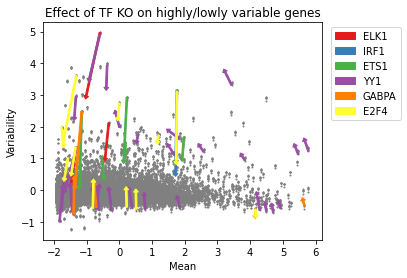

In [66]:
plt.figure(figsize=(5, 4))
color_idx = 0
for g in ko_genes:
    dv_genes = filtered_results[g].query('dv_fdr < 0.1').gene.tolist()
    if len(dv_genes) == 0:
        continue
    moment_df = moments[g]
    
    color = sns.color_palette('Set1')[color_idx]
    color_idx += 1
    
    plt.scatter(moment_df[0]['KO_0'], moment_df[1]['KO_0'], s=1, color='grey')
#     plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_0'], moment_df[1].query('gene in @dv_genes')['KO_0'], s=10)
#     plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_1'], moment_df[1].query('gene in @dv_genes')['KO_1'], s=10)

    for idx, dv_g in enumerate(dv_genes):

        x,y = moment_df[0].query('gene =="{}"'.format(dv_g))['KO_0'].iloc[0], moment_df[1].query('gene =="{}"'.format(dv_g))['KO_0'].iloc[0]
        dx = moment_df[0].query('gene =="{}"'.format(dv_g))['KO_1'].iloc[0] - x
        dy = moment_df[1].query('gene =="{}"'.format(dv_g))['KO_1'].iloc[0] - y
        if idx == 0:
            plt.arrow(x,y, dx, dy, width=0.05, head_length=0.1, color=color, label=g)
        else:
            plt.arrow(x,y, dx, dy, width=0.05, head_length=0.1, color=color)
    plt.xlabel('Mean'); plt.ylabel('Variability'); plt.title('Effect of TF KO on highly/lowly variable genes')
plt.legend( bbox_to_anchor=(1.3, 1))

In [ ]:

for g in ko_genes:
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g)].copy().copy()
    
    subset.obs['group'] = 1
    
    memento.create_groups(subset, label_columns=['KO'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    m_df, var_df = memento.get_1d_moments(subset, groupby='KO')
    
    var_df0 = var_df[['gene', 'KO_0']].rename(columns={'KO_0':'var'})
    var_df0['group'] = 'WT'
    var_df1 = var_df[['gene', 'KO_1']].rename(columns={'KO_1':'var'})
    var_df1['group'] = 'KO'
    
    var_df = pd.concat([var_df0, var_df1])
    var_df['cytokine'] = var_df['gene'].isin(cytokines)
    
    plt.figure(figsize=(2,2))
    sns.boxplot(x='cytokine', y='var', hue='group', data=var_df, fliersize=0.1)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title(g)
    plt.ylim(-0.5, 1.2)
    
#     plt.figure(figsize=(2,3))
#     sns.boxplot(x='cytokine', y='group_1', data=var_df)

In [ ]:
for g in ko_genes:
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g), cytokines].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO', 'guides'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO',
        cov_column='KO', 
        num_boot=20000, 
        verbose=1,
        num_cpus=14)
    guide_df = memento.get_1d_ht_result(subset)
    
    results[g] = memento.get_1d_ht_result(subset)
    moments[g] = memento.get_1d_moments(subset, groupby='KO')

In [123]:
dv_genes = results['YY1'].query('dv_fdr < 0.1').gene.tolist()
moment_df = moments['YY1']

In [136]:
g

'ID3'

In [140]:
moment_df[0].query('gene =="{}"'.format(g))['KO_0'].iloc[0]

-0.39352927

### YY1 - Individual example

Text(0.5, 1.0, 'Effect of YY1 KO on highly/lowly variable genes')

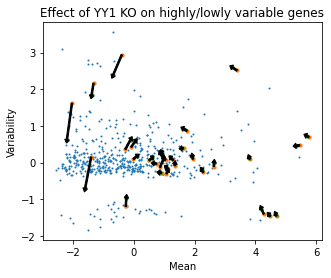

In [144]:
plt.figure(figsize=(5, 4))
plt.scatter(moment_df[0]['KO_0'], moment_df[1]['KO_0'], s=1)
plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_0'], moment_df[1].query('gene in @dv_genes')['KO_0'], s=10)
plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_1'], moment_df[1].query('gene in @dv_genes')['KO_1'], s=10)

for g in dv_genes:
    
    x,y = moment_df[0].query('gene =="{}"'.format(g))['KO_0'].iloc[0], moment_df[1].query('gene =="{}"'.format(g))['KO_0'].iloc[0]
    dx = moment_df[0].query('gene =="{}"'.format(g))['KO_1'].iloc[0] - x
    dy = moment_df[1].query('gene =="{}"'.format(g))['KO_1'].iloc[0] - y
    plt.arrow(x,y, dx, dy, width=0.05, head_length=0.1, color='black')
plt.xlabel('Mean'); plt.ylabel('Variability'); plt.title('Effect of YY1 KO on highly/lowly variable genes')

In [45]:
guide_df = memento.get_1d_ht_result(subset)

In [49]:
guide_df['de_fdr'] = memento.util._fdrcorrect(guide_df['de_pval'])
guide_df['dv_fdr'] = memento.util._fdrcorrect(guide_df['dv_pval'])

In [50]:
guide_df.query('dv_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
74,FN1,-0.462806,0.107527,0.000226,-1.839776,0.289305,0.000088,0.068673,0.037803
353,LYZ,-0.390178,0.130690,0.002700,-1.559115,0.330854,0.000145,0.235326,0.037803


In [ ]:
for g, result in result_1d_dict.items():
    
    result.to_csv(data_path + '/result_1d/{}.csv'.format(g), index=False)